## 08. 异步通信并行策略

UltraOpt的异步通信并行策略代码基本借鉴和使用了`HpBandSter`的代码，您可以参考[HpBandSter文档](https://automl.github.io/HpBandSter/build/html/index.html)来理解这部分教程的内容。

---


UltraOpt支持以下3种并行策略：

|并行策略|策略名|是否支持多保真度|
|-------|-----|-------------|
|串行| Serial| No |
|MapReduce| MapReduce| No |
|异步通信|AsyncComm| **Yes** |

UltraOpt的并行策略默认为 `AsyncComm`， 即 `异步通信`。如果您设置了 `n_jobs=1` 并且 `multi_fidelity_iter_generator=None` ，UltraOpt自动推断您的并行策略为 `Serial` 

如果您想关闭自动推断，可以在`fmin`中设置`auto_identify_serial_strategy=False`

---

我们之前介绍过UltraOpt的设计哲学是以优化器为中心，其中优化器实现了`ask`(样本推荐)和`tell`(结果反馈)两个接口。现在，我们通过一套远程过程调用框架(Pyro4)异步地实现整个过程：

![AsyncComm](https://img-blog.csdnimg.cn/20210102124133367.jpg)

在这个异步通信框架中，有以下几个重要组件：

- **NameServer** 提供按名寻址的命名服务 | [HpBandSter对应文档](https://automl.github.io/HpBandSter/build/html/core/nameserver.html)
- **Master** 整合了优化器与多保真度迭代生成器，只负责任务的调度和优化器更新，不负责配置的评价(如AutoML场景的训练与预测)
- **Worker** 可以部署在集群的不同计算结点上，受Master的调度， 负责对配置进行评价(如AutoML场景的训练与预测)，并将结果返回给`Dispacher`
- **Dispacher** 调度器，负责将`Master`的计算请求发送给`Worker`，和返回`Worker`结果给`Master`


---

下面我们通过一个实例，自定义Worker并绕开`ultraopt.fmin`中启动`Workers`和`Master`

In [1]:
from ultraopt.async_comm.master import Master
from ultraopt.async_comm.worker import Worker
from ultraopt.async_comm.nameserver import NameServer
from ultraopt.utils.net import get_a_free_port
import logging
logging.basicConfig(level=logging.INFO)  # verbose print

### 启动 NameServer

In [2]:
ns_host = "0.0.0.0"
port = get_a_free_port(9090, ns_host)

In [3]:
NS = NameServer(run_id="learn_ultraopt", host=ns_host, port=port)

In [4]:
NS.start()

('0.0.0.0', 9090)

### 启动 Worker

启动用于AutoML场景的`Worker` (仅作为参考，您可以根据自己的需求进行设计)

- 方案1. 采用默认`Worker`，用`评价函数`对其初始化

In [5]:
# 引入automl评价函数
from ultraopt.tests.automl import evaluator

In [6]:
worker1 = Worker(
    run_id="learn_ultraopt",
    nameserver=ns_host,
    nameserver_port=port,
    worker_id=0
)

用`评价函数`对其初始化

In [7]:
worker1.initialize(evaluator) 

采用**线程**在**后台**运行Worker

In [8]:
worker1.run(
    background=True,
    concurrent_type="thread" # 也可以采用 process ，但可能会在Python3.7+版本启动失败，故建议用线程
)

INFO:Worker[0]:WORKER(worker_id='ultraopt.run_learn_ultraopt.worker.tqc-PC.25369.0_139894424450816'): start listening for jobs


- 方案2. 继承默认`Worker`为专用`Worker`，重写`compute`函数

我们在 `05. Implement a Simple AutoML System` 教程中学习过， AutoML评价器依赖 `训练数据` ，在实际应用中，`训练数据` 往往都很大。上文演示的用**本地函数**简单地启动多个`Worker`的方法就不能在**集群环境**下使用了。

在**集群环境**下，我们应该在每个计算结点单独启动`Worker`。这就需要我们继承默认`Worker`为**专用**`Worker`，并重写`compute`函数。

我们参考教程 `06. Combine Multi-Fidelity Optimization` 或者 `ultraopt.tests.automl.Evaluator` 关于评价器的实现，开发 `AutoMLWorker` 。我们需要注意3点：

- note 1 : 记得调用基类的构造函数
- note 2 : 记得重载 `compute` 函数
- note 3 : 记得 `compute` 函数的返回值为字典类型，且必须含有 `loss` 键

In [9]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold  
import numpy as np

from ultraopt.hdl import layering_config

default_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

class AutoMLWorker(Worker):
    def __init__(
        self,
        X, y,
        metric="accuracy",
        cv=default_cv,
        **kwargs
    ):
        self.X = X
        self.y = y
        self.metric = metric
        self.cv = cv
        # note 1 : 记得调用基类的构造函数
        super(AutoMLWorker, self).__init__(**kwargs)
    
    # note 2 : 记得重载 `compute` 函数
    def compute(self, config_id, config, config_info, budget, working_directory):
        '''重写基类的 compute 函数'''
        layered_dict = layering_config(config)
        AS_HP = layered_dict['classifier'].copy()
        AS, HP = AS_HP.popitem()
        ML_model = eval(AS)(**HP)
        sample_ratio  = budget
        scores = []
        for i, (train_ix, valid_ix) in enumerate(self.cv.split(X, y)):
            rng = np.random.RandomState(i)
            size = int(train_ix.size * sample_ratio)
            train_ix = rng.choice(train_ix, size, replace=False)
            X_train = X[train_ix, :]
            y_train = y[train_ix]
            X_valid = X[valid_ix, :]
            y_valid = y[valid_ix]
            ML_model.fit(X_train, y_train)
            y_pred = ML_model.predict(X_valid)
            score = eval(f"sklearn.metrics.{self.metric}_score")(y_valid, y_pred)
            scores.append(score)
        score = np.mean(scores)
        # note 3 : 记得 `compute` 函数的返回值为字典类型，且必须含有 `loss` 键
        return {
            "loss": 1 - score  
        }

模拟在计算结点中加载本地数据并实例化一个worker

In [10]:
X, y = load_digits(return_X_y=True)
worker2 = AutoMLWorker(
    X, y, 
    # 与异步通信有关的配置保持不变
    run_id="learn_ultraopt",
    nameserver=ns_host,
    nameserver_port=port,
    worker_id=1
)

In [11]:
worker2.run(background=True)

INFO:Worker[1]:WORKER(worker_id='ultraopt.run_learn_ultraopt.worker.tqc-PC.25369.1_139894424450816'): start listening for jobs


### 启动 Master

In [12]:
from ultraopt.optimizer import ETPEOptimizer
from ultraopt.multi_fidelity import HyperBandIterGenerator
from ultraopt.utils.progress import default_callback
from ultraopt.tests.automl import config_space
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 控制tabular_nn 日志等级
logging.getLogger("tabular_nn.component.embedding_encoder.EmbeddingEncoder").setLevel(logging.WARNING)
logging.getLogger("tabular_nn.entity_embedding_nn.TrainEntityEmbeddingNN").setLevel(logging.WARNING)

In [14]:
optimizer = ETPEOptimizer()

In [15]:
iter_generator = HyperBandIterGenerator(min_budget=1/4, max_budget=1, eta=2)

In [16]:
optimizer.initialize(config_space=config_space, budgets=iter_generator.get_budgets())

In [17]:
master = Master(
    run_id="learn_ultraopt", 
    optimizer=optimizer, 
    iter_generator=iter_generator, 
    progress_callback=default_callback,
    checkpoint_file=None, # 不保存检查点
    checkpoint_freq=1,
    nameserver=ns_host, 
)

In [18]:
master.run(n_iterations=30)

  3%|▎         | 4/130 [00:00<00:16,  7.52trial/s, max budget: 0.25, best loss: 0.048]

INFO:incumbent_trajectory:Challenger (0.0328) is better than incumbent (0.0774) when budget is (1/2).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:n_neighbors : 52 -> 5
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:p : '2:int' -> '1:int'


  5%|▌         | 7/130 [00:00<00:16,  7.33trial/s, max budget: 0.25, best loss: 0.048]

INFO:incumbent_trajectory:Challenger (0.0289) is better than incumbent (0.0328) when budget is (1/2).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:n_neighbors : 5 -> 1


  7%|▋         | 9/130 [00:01<00:14,  8.46trial/s, max budget: 0.25, best loss: 0.048]

INFO:incumbent_trajectory:Challenger (0.0184) is better than incumbent (0.0189) when budget is (1).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:n_neighbors : 5 -> 1


 44%|████▍     | 57/130 [00:14<00:23,  3.08trial/s, max budget: 1.0, best loss: 0.018] 

INFO:incumbent_trajectory:Challenger (0.0217) is better than incumbent (0.0289) when budget is (1/2).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:p : '1:int' -> '2:int'


 45%|████▌     | 59/130 [00:15<00:18,  3.86trial/s, max budget: 1.0, best loss: 0.018]

INFO:incumbent_trajectory:Challenger (0.0139) is better than incumbent (0.0184) when budget is (1).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:p : '1:int' -> '2:int'


 47%|████▋     | 61/130 [00:15<00:17,  3.90trial/s, max budget: 1.0, best loss: 0.014]

INFO:incumbent_trajectory:Challenger (0.0128) is better than incumbent (0.0139) when budget is (1).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:n_neighbors : 1 -> 3


 58%|█████▊    | 76/130 [00:17<00:08,  6.48trial/s, max budget: 1.0, best loss: 0.013]

INFO:incumbent_trajectory:Challenger (0.0117) is better than incumbent (0.0128) when budget is (1).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:n_neighbors : 3 -> 4
INFO:incumbent_trajectory:Challenger (0.0345) is better than incumbent (0.0479) when budget is (1/4).
INFO:incumbent_trajectory:Changes in incumbent:
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:n_neighbors : 1 -> 5
INFO:incumbent_trajectory:  classifier:KNeighborsClassifier:p : '1:int' -> '2:int'


100%|██████████| 130/130 [00:23<00:00,  5.49trial/s, max budget: 1.0, best loss: 0.012]


我们可以对**优化过程**和**优化结果**进行可视化分析：

In [19]:
from ultraopt import FMinResult

In [20]:
result = FMinResult(optimizer)
result

+--------------------------------------------------------------------------------------------------------------------------+
| HyperParameters                                     | Optimal Value                                                      |
+-----------------------------------------------------+----------------------+----------------------+----------------------+
| classifier:__choice__                               | KNeighborsClassifier | KNeighborsClassifier | KNeighborsClassifier |
| classifier:KNeighborsClassifier:n_neighbors         | 5                    | 1                    | 4                    |
| classifier:KNeighborsClassifier:p                   | 2:int                | 2:int                | 2:int                |
| classifier:KNeighborsClassifier:weights             | distance             | distance             | distance             |
| classifier:LinearSVC:C                              | -                    | -                    | -                    |


我们之前在后台启动了`2`个`Worker`， 所以**并行图**显示时序中的最大并行数为`2`

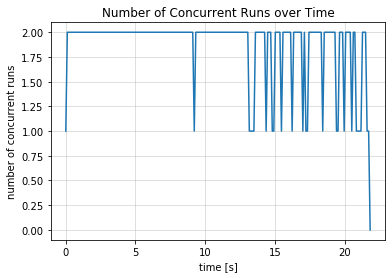

In [21]:
result.plot_concurrent_over_time(num_points=200);

绘制之前学习过的其他图片：

In [22]:
import pylab as plt

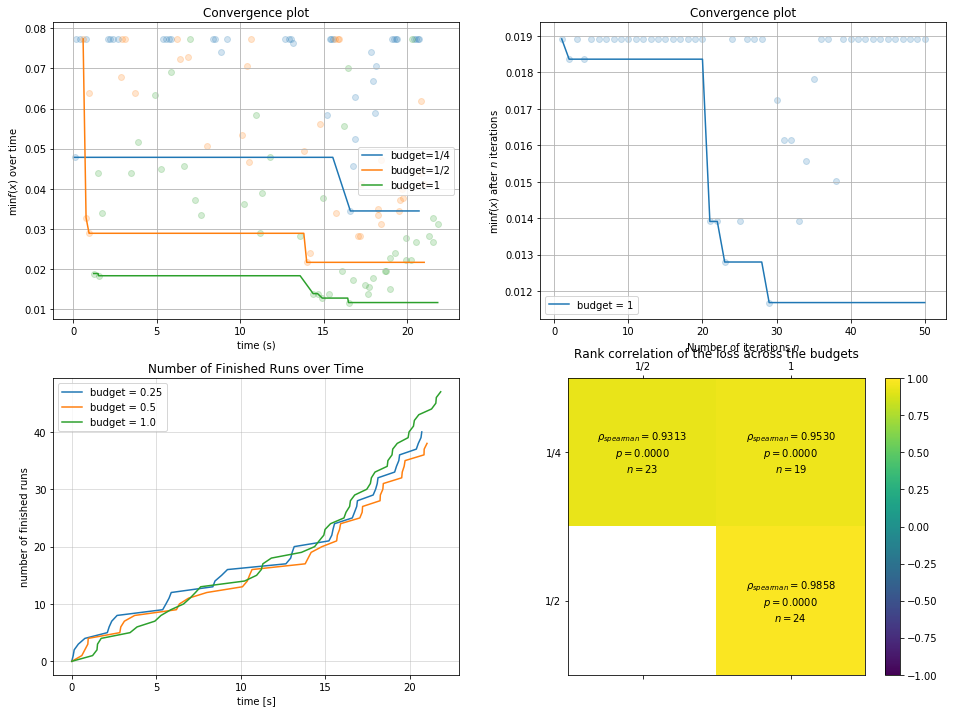

In [23]:
plt.rcParams['figure.figsize'] = (16, 12)
plt.subplot(2, 2, 1)
result.plot_convergence_over_time();
plt.subplot(2, 2, 2)
ax = result.plot_convergence_over_iter(budget=1, name="budget = 1")
plt.subplot(2, 2, 3)
result.plot_finished_over_time();
plt.subplot(2, 2, 4)
result.plot_correlation_across_budgets();

### 释放资源

完成计算后，我们需要将后台的`Worker`等线程关闭，避免对端口等资源的长时间占用。

我们首先关闭 `master` , 关闭master时会自动关闭所有被连接的 `worker`

In [24]:
master.shutdown(shutdown_workers=True)

INFO:ultraopt.async_comm.master.Master:HBMASTER: shutdown initiated, shutdown_workers = True


然后关闭 `NameServer`

In [25]:
NS.shutdown()